<a href="https://colab.research.google.com/github/pascalghanimi/Ski-Classification-AI/blob/main/Feature_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import joblib
import numpy as np

pkl_name = "G_1Simon_PD"

# Lade die Daten
result = joblib.load(f"/content/demo_{pkl_name}.pkl")

In [ ]:
from typing_extensions import dataclass_transform
# Hier wird der COM berechnet

HAND_FOREARM_SCALE_FACTOR = 0.75

# Definiere die Segmente und relative Faktoren als Dictionary
segments = {
    "head_and_neck": {"points": (43, 40), "factor": 0.567}, # 43 ist Head, 40 ist Thorax
    "torso": {"points": (40, 8), "factor": 0.562}, # 40 ist Thorax, 8 ist Mid Hip
    "upper_arm_right": {"points": (2, 3), "factor": 0.564},  # 2 ist rechte Schulter, 3 ist rechter Ellbogen
    "upper_arm_left": {"points": (5, 6), "factor": 0.564},  # 5 ist linke Schulter, 6 ist linker Ellbogen
    "lower_arm_right": {"points": (3, 4), "factor": 0.57}, # 3 ist rechter Ellbogen, 4 ist rechtes Handgelenk
    "lower_arm_left": {"points": (6, 7), "factor": 0.57}, # 6 ist linker Ellbogen, 7 ist linkes Handgelenk
    "hand_right": {"factor": 0.468}, # Faktor ist hier 46.8, weil wir bei der Berechnung später bei der Wrist anfangen und die Länge des Ellbogens hinzuaddieren, hier also in die andere Richtung gehen als sonst
    "hand_left": {"factor": 0.468},
    "thigh_right": {"points": (9, 10), "factor": 0.567},  # 9 ist rechte Hüfte, 10 ist rechtes Knie
    "thigh_left": {"points": (12, 13), "factor": 0.567}, # 12 ist linke Hüfte, 13 ist linkes Knie
    "calf_right": {"points": (10, 11), "factor": 0.567}, # 10 ist rechtes Knie, 11 ist rechtes Ankle
    "calf_left": {"points": (13, 14), "factor": 0.567}, # 13 ist linkes Knie, 14 ist linkes Ankle
    "foot_right": {"points": (11, 22), "factor": 0.5}, # 11 ist rechtes Ankle, 22 ist großer Zeh rechts
    "foot_left": {"points": (14, 19), "factor": 0.5} # 14 ist linkes Ankle, 19 ist großer Zeh links
}


com_of_segments = {}

for i, frame in enumerate(list(result.keys())):
  com_of_segment = {}
  for segment, data in segments.items():
    if (segment == "hand_right"):
      com_position = np.array(result[frame]["3d_joints"][0][4]) + (
      (np.array(result[frame]["3d_joints"][0][4]) - np.array(result[frame]["3d_joints"][0][3]))
      * HAND_FOREARM_SCALE_FACTOR
      ) * data["factor"]
      com_of_segment[segment] = com_position
    elif segment == "hand_left":
      com_position = np.array(result[frame]["3d_joints"][0][7]) + (
      (np.array(result[frame]["3d_joints"][0][7]) - np.array(result[frame]["3d_joints"][0][6]))
      * HAND_FOREARM_SCALE_FACTOR
      ) * data["factor"]
      com_of_segment[segment] = com_position
    else:
      point_higher, point_lower = data["points"]
      com_position = np.array(result[frame]["3d_joints"][0][point_lower]) + ((np.array(result[frame]["3d_joints"][0][point_higher]) - np.array(result[frame]["3d_joints"][0][point_lower])) * data["factor"])
      com_of_segment[segment] = com_position


  com_of_segments[i] = com_of_segment


for i in range(3):
  print(com_of_segments[i]["head_and_neck"], "Head and Neck COM")

for i in range(3):
    print(com_of_segments[i]["lower_arm_right"], "Lower Arm Right COM")

for i in range(3):
  print(com_of_segments[i]["hand_right"], "Hand Right COM")



[ 0.09194668 -0.7722711  -0.27621657] Head and Neck COM
[ 0.09169395 -0.7715338  -0.27297097] Head and Neck COM
[ 0.08792531 -0.77454865 -0.27055484] Head and Neck COM
[-0.3711899  -0.4516481  -0.14260155] Lower Arm Right COM
[-0.36540994 -0.44705814 -0.1366562 ] Lower Arm Right COM
[-0.36704326 -0.4479955  -0.13333759] Lower Arm Right COM
[-0.52513474 -0.3335177  -0.29375967] Hand Right COM
[-0.5208394  -0.33156535 -0.28774476] Hand Right COM
[-0.52147126 -0.3296596  -0.28119877] Hand Right COM


In [ ]:
relative_masses = {
    "head_and_neck": 0.082,  # Beispiel aus Tabelle Hall
    "torso": 0.4684,
    "upper_arm_right": 0.0325,
    "upper_arm_left": 0.0325,
    "lower_arm_right": 0.0196,  # Unterarmgewicht, basierend auf Literaturwerten
    "lower_arm_left": 0.0196,
    "hand_right": 0.0061,  # Handgewicht, basierend auf Literaturwerten
    "hand_left": 0.0061,
    "thigh_right": 0.105,
    "thigh_left": 0.105,
    "calf_right": 0.0475,
    "calf_left": 0.0475,
    "foot_right": 0.0143,
    "foot_left": 0.0143
}


# Liste, die die COMs für alle Frames speichert
COM_xyz_values = {}

for frame in com_of_segments:
  COM_xyz = np.sum([
    np.array(com_of_segments[frame][segment]) * relative_masses[segment]
    for segment in relative_masses.keys()
  ], axis=0)
  COM_xyz_values[frame] = COM_xyz

print(COM_xyz_values)


{0: array([ 0.04153949, -0.2959132 , -0.10362449], dtype=float32), 1: array([ 0.0403835 , -0.2938769 , -0.10000588], dtype=float32), 2: array([ 0.03755197, -0.29733688, -0.09969928], dtype=float32), 3: array([ 0.03678393, -0.29743358, -0.10215095], dtype=float32), 4: array([ 0.03347517, -0.29970765, -0.10669276], dtype=float32), 5: array([ 0.02993865, -0.30194458, -0.10736226], dtype=float32), 6: array([ 0.02950811, -0.30069336, -0.10726541], dtype=float32), 7: array([ 0.02503376, -0.29666358, -0.11104409], dtype=float32), 8: array([ 0.023225  , -0.2982809 , -0.11139157], dtype=float32), 9: array([ 0.02063569, -0.2929655 , -0.11836599], dtype=float32), 10: array([ 0.01956142, -0.29410776, -0.11868991], dtype=float32), 11: array([ 0.01199607, -0.28701925, -0.12288789], dtype=float32), 12: array([ 0.00751375, -0.2907509 , -0.12292959], dtype=float32), 13: array([ 0.00361334, -0.29020044, -0.12455121], dtype=float32), 14: array([-0.00441076, -0.2761854 , -0.14085104], dtype=float32), 15: 

In [ ]:
r_ankle = {}
l_ankle = {}
center_ankle = {}

for i, frame in enumerate(list(result.keys())):
  r_ankle[i] = result[frame]["3d_joints"][0][11]
  l_ankle[i] = result[frame]["3d_joints"][0][14]
  center_ankle[i] = (result[frame]["3d_joints"][0][11] + result[frame]["3d_joints"][0][14]) / 2

print(len(r_ankle))
print(len(COM_xyz_values))


117
117


In [ ]:
COM_to_ground = {}

for i in COM_xyz_values:
  distance = np.linalg.norm(COM_xyz_values[i] - center_ankle[i])
  COM_to_ground[i] = distance

print(COM_to_ground)

{0: 0.83516055, 1: 0.83531225, 2: 0.8258441, 3: 0.8233454, 4: 0.8134174, 5: 0.808589, 6: 0.809546, 7: 0.8108446, 8: 0.8079058, 9: 0.80322814, 10: 0.80321217, 11: 0.7997785, 12: 0.788425, 13: 0.7929602, 14: 0.78522795, 15: 0.7817862, 16: 0.7795192, 17: 0.7715101, 18: 0.7714118, 19: 0.7654959, 20: 0.7735648, 21: 0.7695321, 22: 0.7670833, 23: 0.7636223, 24: 0.7623254, 25: 0.75666046, 26: 0.7539136, 27: 0.75270075, 28: 0.75509053, 29: 0.75143194, 30: 0.75414115, 31: 0.7570532, 32: 0.76489687, 33: 0.7735289, 34: 0.7897625, 35: 0.7994213, 36: 0.8149826, 37: 0.82652134, 38: 0.8428307, 39: 0.8455673, 40: 0.8630697, 41: 0.87122834, 42: 0.8809966, 43: 0.8800359, 44: 0.8854804, 45: 0.8947362, 46: 0.889527, 47: 0.9010812, 48: 0.90366524, 49: 0.90048194, 50: 0.90168905, 51: 0.8974404, 52: 0.89560395, 53: 0.8942573, 54: 0.88930565, 55: 0.88446933, 56: 0.8838185, 57: 0.88569283, 58: 0.88442343, 59: 0.8735657, 60: 0.86955655, 61: 0.86682963, 62: 0.8604068, 63: 0.8600429, 64: 0.86103797, 65: 0.8538127,

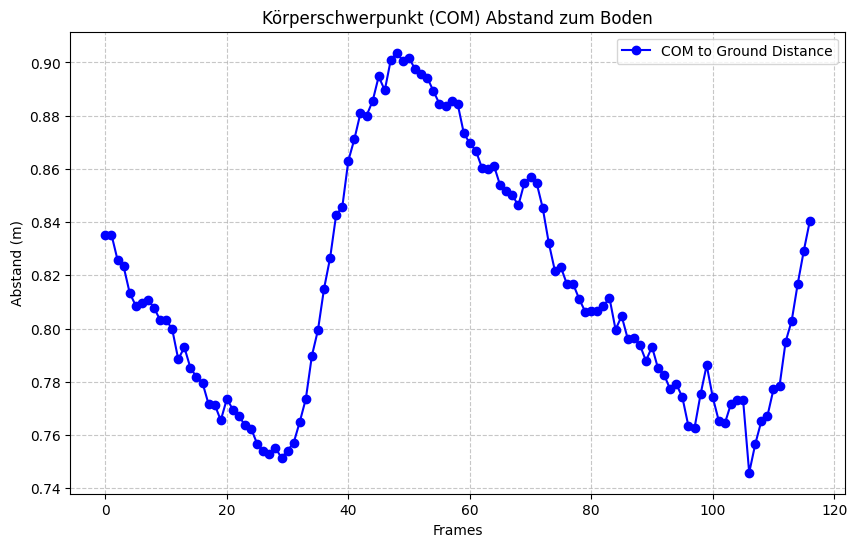

In [ ]:
import matplotlib.pyplot as plt

# COM_to_ground-Daten, die bereits berechnet
frames = list(COM_to_ground.keys())
distances = list(COM_to_ground.values())

# Plot erstellen
plt.figure(figsize=(10, 6))
plt.plot(frames, distances, marker='o', linestyle='-', color='b', label="COM to Ground Distance")
plt.title("Körperschwerpunkt (COM) Abstand zum Boden")
plt.xlabel("Frames")
plt.ylabel("Abstand (m)")
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend()
plt.show()


In [ ]:
# Hier wird das Feature Kniewinkel für jeden Frame berechnet
r_hip_num = 9
r_knee_num = 10
r_ankle_num = 11
r_shoulder_num = 2
r_ellbow_num = 3
l_hip_num = 12
l_knee_num = 13
l_ankle_num = 14
l_shoulder_num = 5
l_ellbow_num = 6


knee_angles_right = {}
knee_angles_left = {}

for i, frame in enumerate(list(result.keys())):
  vector_right_hip_knee = result[frame]['3d_joints'][0][r_knee_num] - result[frame]['3d_joints'][0][r_hip_num]
  vector_left_hip_knee = result[frame]['3d_joints'][0][l_knee_num] - result[frame]['3d_joints'][0][l_hip_num]
  vector_right_knee_ankle = result[frame]['3d_joints'][0][r_ankle_num] - result[frame]['3d_joints'][0][r_knee_num]
  vector_left_knee_ankle = result[frame]['3d_joints'][0][l_ankle_num] - result[frame]['3d_joints'][0][l_knee_num]

  right_leg_dot_product = np.dot(vector_right_hip_knee, vector_right_knee_ankle)
  left_leg_dot_product = np.dot(vector_left_hip_knee, vector_left_knee_ankle)

  right_hip_knee_length = np.linalg.norm(vector_right_hip_knee)
  left_hip_knee_length = np.linalg.norm(vector_left_hip_knee)
  right_knee_ankle_length = np.linalg.norm(vector_right_knee_ankle)
  left_knee_ankle_length = np.linalg.norm(vector_left_knee_ankle)


  knee_angle_right = np.degrees(np.arccos(right_leg_dot_product / (right_hip_knee_length * right_knee_ankle_length)))
  knee_angle_left = np.degrees(np.arccos(left_leg_dot_product / (left_hip_knee_length * left_knee_ankle_length)))

  knee_angles_right[i] = knee_angle_right
  knee_angles_left[i] = knee_angle_left


for i in range(5):
  print(knee_angles_right)


{0: 40.84227, 1: 41.973206, 2: 46.86987, 3: 47.376663, 4: 49.918045, 5: 51.678543, 6: 50.820187, 7: 49.04827, 8: 48.258812, 9: 48.435028, 10: 49.838074, 11: 49.48597, 12: 54.425312, 13: 54.043686, 14: 50.954998, 15: 53.506886, 16: 56.381557, 17: 54.334164, 18: 54.814735, 19: 56.371414, 20: 54.72461, 21: 56.457844, 22: 56.17979, 23: 58.377308, 24: 58.04186, 25: 58.902565, 26: 60.71873, 27: 59.92236, 28: 61.4739, 29: 63.10216, 30: 63.166767, 31: 62.922096, 32: 63.19191, 33: 61.500896, 34: 59.666588, 35: 58.013638, 36: 54.50339, 37: 53.438923, 38: 49.18715, 39: 48.89138, 40: 43.4758, 41: 39.517, 42: 37.079933, 43: 33.593414, 44: 29.587498, 45: 26.593208, 46: 23.769955, 47: 26.768496, 48: 25.66087, 49: 23.984716, 50: 24.30616, 51: 23.880774, 52: 23.201101, 53: 23.701902, 54: 29.347485, 55: 29.093716, 56: 28.776756, 57: 26.35002, 58: 26.911762, 59: 25.732872, 60: 24.35519, 61: 23.237299, 62: 26.628218, 63: 25.127874, 64: 24.582829, 65: 25.053017, 66: 24.857733, 67: 24.667017, 68: 25.654608,

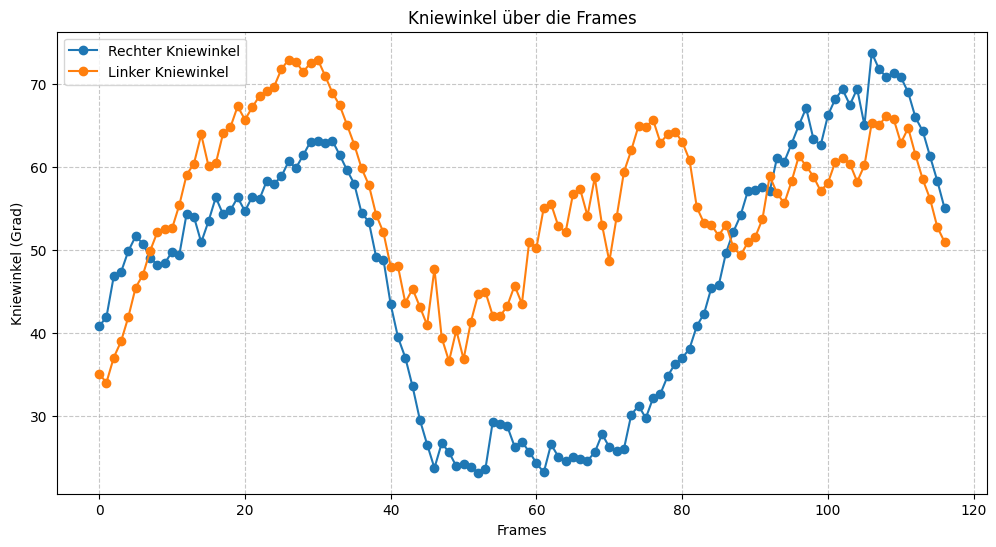

In [ ]:
import matplotlib.pyplot as plt

# Frames extrahieren
frames = list(knee_angles_right.keys())

# Kniewinkel extrahieren
right_knee_angles = [knee_angles_right[frame] for frame in frames]
left_knee_angles = [knee_angles_left[frame] for frame in frames]


# Plot erstellen
plt.figure(figsize=(12, 6))

# Kniewinkel (rechts) plotten
plt.plot(frames, right_knee_angles, label="Rechter Kniewinkel", linestyle='-', marker='o')

# Kniewinkel (links) plotten
plt.plot(frames, left_knee_angles, label="Linker Kniewinkel", linestyle='-', marker='o')

# Plot-Details
plt.title("Kniewinkel über die Frames")
plt.xlabel("Frames")
plt.ylabel("Kniewinkel (Grad)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()


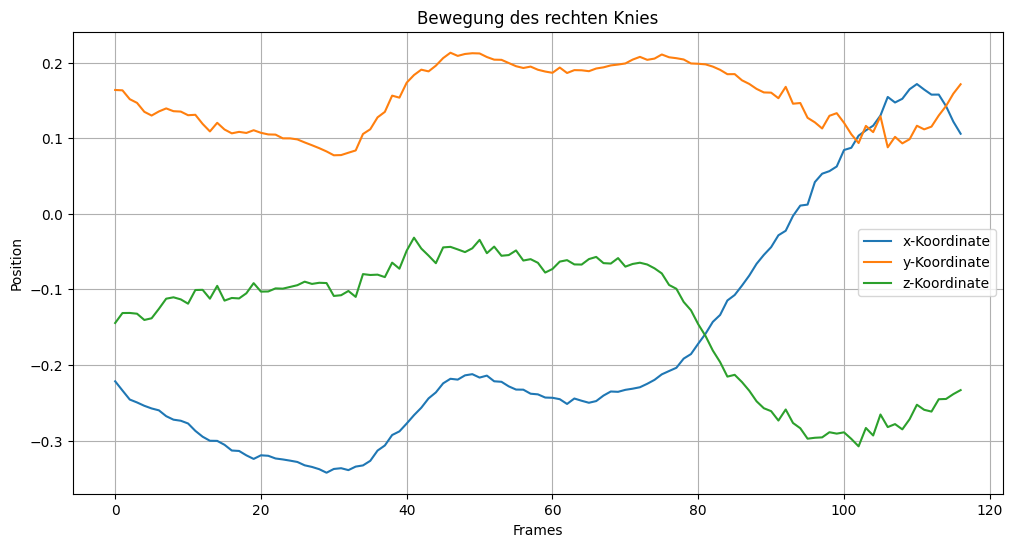

In [ ]:
#exemplarische Darstellung des rechten Knies

import matplotlib.pyplot as plt

x_coords = [result[frame]['3d_joints'][0][r_knee_num][0] for frame in result.keys()]
y_coords = [result[frame]['3d_joints'][0][r_knee_num][1] for frame in result.keys()]
z_coords = [result[frame]['3d_joints'][0][r_knee_num][2] for frame in result.keys()]

plt.figure(figsize=(12, 6))
plt.plot(x_coords, label="x-Koordinate")
plt.plot(y_coords, label="y-Koordinate")
plt.plot(z_coords, label="z-Koordinate")
plt.title("Bewegung des rechten Knies")
plt.xlabel("Frames")
plt.ylabel("Position")
plt.legend()
plt.grid(True)
plt.show()

# x-Achse: Die Bewegung des Knies entlang der x-Achse ist logisch, da der Fahrer nach rechts und links fährt. Die starke Veränderung in den Werten passt zu einer Schwungbewegung.
# y-Achse: Diese sollte stabil bleiben, da das Knie (wie du sagst) nicht groß um die y-Achse rotiert. Die minimalen Änderungen könnten durch Tracking-Rauschen entstehen.
# z-Achse: Leichte Schwankungen in z sind plausibel, da das Knie aufgrund von Hoch- und Tiefbewegungen während des Fahrens minimal variiert.

In [ ]:
# Hier wird der Winkel zwischen den Gelenkspunkten und der z-Achse berechnet

z_vector = np.array([0, 0, -1])  # Z-Vektor für die Berechnung, mit -1, weil man weier nach unten geht (so als würde man zum Ankle weitergehen, nur diesmal gerade nach unten)
angles_z = {}

for i, frame in enumerate(list(result.keys())):
    # Dictionary für die Winkel eines Frames
    angle_dic = {}

    # Gelenkpunkte des aktuellen Frames
    r_knee = result[frame]['3d_joints'][0][r_knee_num]
    l_knee = result[frame]['3d_joints'][0][l_knee_num]
    r_shoulder = result[frame]['3d_joints'][0][r_shoulder_num]
    l_shoulder = result[frame]['3d_joints'][0][l_shoulder_num]
    r_ellbow = result[frame]['3d_joints'][0][r_ellbow_num]
    l_ellbow = result[frame]['3d_joints'][0][l_ellbow_num]
    r_ankle = result[frame]['3d_joints'][0][r_ankle_num]
    l_ankle = result[frame]['3d_joints'][0][l_ankle_num]
    r_hip = result[frame]['3d_joints'][0][r_hip_num]
    l_hip = result[frame]['3d_joints'][0][l_hip_num]

    #Gelenksvektoren
    vector_shoulder_to_ellbow_right = r_ellbow - r_shoulder
    vector_shoulder_to_ellbow_left = l_ellbow - l_shoulder
    vector_hip_to_knee_right = r_knee - r_hip
    vector_hip_to_knee_left = l_knee - l_hip
    vector_knee_to_ankle_right = r_ankle - r_knee
    vector_knee_to_ankle_left = l_ankle - l_knee

    # Berechnung der Winkel zur z-Achse für jeden Gelenkpunkt
    angle_dic["angle_shoulder_to_ellbow_right"] = np.degrees(np.arccos(np.dot(vector_shoulder_to_ellbow_right, z_vector) / (np.linalg.norm(vector_shoulder_to_ellbow_right) * np.linalg.norm(z_vector))))
    angle_dic["angle_shoulder_to_ellbow_left"] = np.degrees(np.arccos(np.dot(vector_shoulder_to_ellbow_left, z_vector) / (np.linalg.norm(vector_shoulder_to_ellbow_left) * np.linalg.norm(z_vector))))
    angle_dic["angle_hip_to_knee_right"] = np.degrees(np.arccos(np.dot(vector_hip_to_knee_right, z_vector) / (np.linalg.norm(vector_hip_to_knee_right) * np.linalg.norm(z_vector))))
    angle_dic["angle_hip_to_knee_left"] = np.degrees(np.arccos(np.dot(vector_hip_to_knee_left, z_vector) / (np.linalg.norm(vector_hip_to_knee_left) * np.linalg.norm(z_vector))))
    angle_dic["angle_knee_to_ankle_right"] = np.degrees(np.arccos(np.dot(vector_knee_to_ankle_right, z_vector) / (np.linalg.norm(vector_knee_to_ankle_right) * np.linalg.norm(z_vector))))
    angle_dic["angle_knee_to_ankle_left"] = np.degrees(np.arccos(np.dot(vector_knee_to_ankle_left, z_vector) / (np.linalg.norm(vector_knee_to_ankle_left) * np.linalg.norm(z_vector))))


    # Speichern des Frame-Dictionaries im übergeordneten Dictionary
    angles_z[i] = angle_dic

# Ausgabe des finalen Dictionaries
print(angles_z[0])


{'angle_shoulder_to_ellbow_right': 117.36992088833398, 'angle_shoulder_to_ellbow_left': 114.22500652943233, 'angle_hip_to_knee_right': 61.61126844024062, 'angle_hip_to_knee_left': 65.71761321509011, 'angle_knee_to_ankle_right': 101.166166084597, 'angle_knee_to_ankle_left': 100.46167620867153}


In [ ]:
import numpy as np

x_vector = np.array([1, 0, 0])  # Richtung entlang der x-Achse
angles_x = {}

for i, frame in enumerate(list(result.keys())):
    angle_dic = {}

    # Gelenkpunkte
    r_knee = result[frame]['3d_joints'][0][r_knee_num]
    l_knee = result[frame]['3d_joints'][0][l_knee_num]
    r_shoulder = result[frame]['3d_joints'][0][r_shoulder_num]
    l_shoulder = result[frame]['3d_joints'][0][l_shoulder_num]
    r_ellbow = result[frame]['3d_joints'][0][r_ellbow_num]
    l_ellbow = result[frame]['3d_joints'][0][l_ellbow_num]
    r_ankle = result[frame]['3d_joints'][0][r_ankle_num]
    l_ankle = result[frame]['3d_joints'][0][l_ankle_num]
    r_hip = result[frame]['3d_joints'][0][r_hip_num]
    l_hip = result[frame]['3d_joints'][0][l_hip_num]

    # Gelenksvektoren
    vector_shoulder_to_ellbow_right = r_ellbow - r_shoulder
    vector_shoulder_to_ellbow_left = l_ellbow - l_shoulder
    vector_hip_to_knee_right = r_knee - r_hip
    vector_hip_to_knee_left = l_knee - l_hip
    vector_knee_to_ankle_right = r_ankle - r_knee
    vector_knee_to_ankle_left = l_ankle - l_knee

    # Berechnung der Winkel zur x-Achse
    angle_dic["angle_shoulder_to_ellbow_right"] = np.degrees(np.arccos(np.dot(vector_shoulder_to_ellbow_right, x_vector) / (np.linalg.norm(vector_shoulder_to_ellbow_right) * np.linalg.norm(x_vector))))
    angle_dic["angle_shoulder_to_ellbow_left"] = np.degrees(np.arccos(np.dot(vector_shoulder_to_ellbow_left, x_vector) / (np.linalg.norm(vector_shoulder_to_ellbow_left) * np.linalg.norm(x_vector))))
    angle_dic["angle_hip_to_knee_right"] = np.degrees(np.arccos(np.dot(vector_hip_to_knee_right, x_vector) / (np.linalg.norm(vector_hip_to_knee_right) * np.linalg.norm(x_vector))))
    angle_dic["angle_hip_to_knee_left"] = np.degrees(np.arccos(np.dot(vector_hip_to_knee_left, x_vector) / (np.linalg.norm(vector_hip_to_knee_left) * np.linalg.norm(x_vector))))
    angle_dic["angle_knee_to_ankle_right"] = np.degrees(np.arccos(np.dot(vector_knee_to_ankle_right, x_vector) / (np.linalg.norm(vector_knee_to_ankle_right) * np.linalg.norm(x_vector))))
    angle_dic["angle_knee_to_ankle_left"] = np.degrees(np.arccos(np.dot(vector_knee_to_ankle_left, x_vector) / (np.linalg.norm(vector_knee_to_ankle_left) * np.linalg.norm(x_vector))))

    angles_x[i] = angle_dic

# Ausgabe für Frame 0
print(angles_x[0])


{'angle_shoulder_to_ellbow_right': 136.29420850636885, 'angle_shoulder_to_ellbow_left': 44.61735059183731, 'angle_hip_to_knee_right': 111.31139658703857, 'angle_hip_to_knee_left': 59.435956374732555, 'angle_knee_to_ankle_right': 103.6148286675598, 'angle_knee_to_ankle_left': 61.7980669073186}


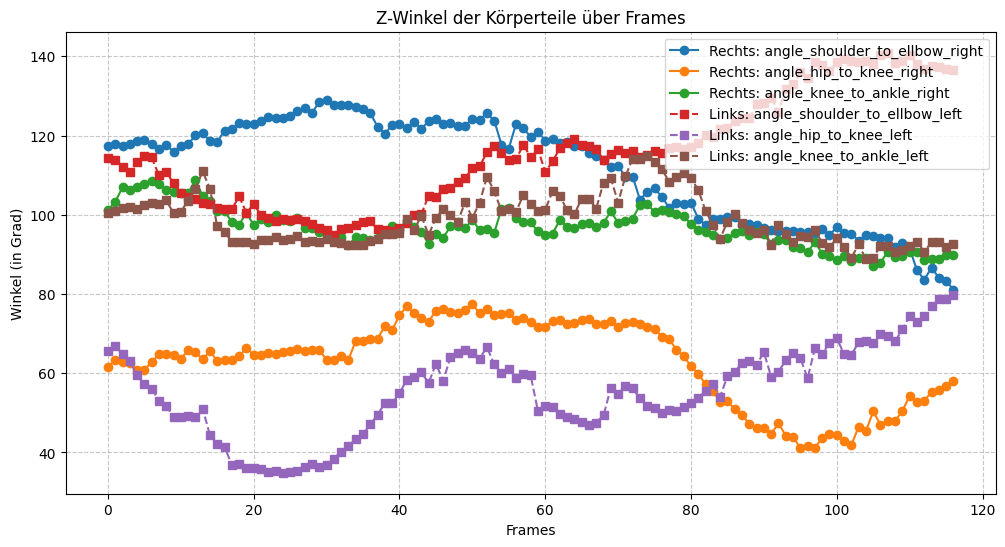

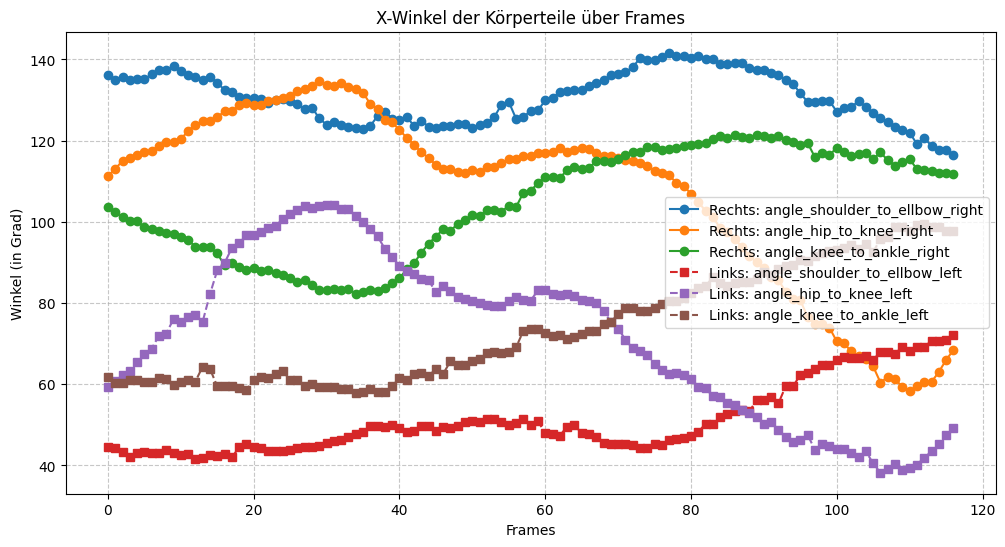

In [ ]:
import matplotlib.pyplot as plt

def plot_angles(angles, axis):
    """
    Plottet die Winkel der rechten und linken Körperteile über alle Frames.

    Parameter:
    - angles (dict): Ein Dictionary mit Frame-Nummern als Schlüssel und Dictionaries mit Winkelinformationen als Werte.
    - axis (str): Achse ('x', 'y', 'z') für den Titel.
    """
    sorted_frames = sorted(angles.keys())

    # Winkel-Keys für rechte und linke Körperseite extrahieren
    right_angle_keys = [key for key in angles[next(iter(angles))].keys() if "_right" in key]
    left_angle_keys = [key for key in angles[next(iter(angles))].keys() if "_left" in key]

    if not right_angle_keys and not left_angle_keys:
        print(f"Keine passenden Winkel in {axis}-Achse gefunden.")
        return

    angle_values_right = {key: [] for key in right_angle_keys}
    angle_values_left = {key: [] for key in left_angle_keys}

    # Winkelwerte für jeden Frame sammeln
    for frame in sorted_frames:
        for key in right_angle_keys:
            angle_values_right[key].append(angles[frame][key])
        for key in left_angle_keys:
            angle_values_left[key].append(angles[frame][key])

    plt.figure(figsize=(12, 6))

    # Rechte Körperhälfte plotten
    for key in right_angle_keys:
        plt.plot(sorted_frames, angle_values_right[key], marker='o', linestyle='-', label=f"Rechts: {key}")

    # Linke Körperhälfte plotten
    for key in left_angle_keys:
        plt.plot(sorted_frames, angle_values_left[key], marker='s', linestyle='--', label=f"Links: {key}")

    plt.xlabel('Frames')
    plt.ylabel('Winkel (in Grad)')
    plt.title(f'{axis.upper()}-Winkel der Körperteile über Frames')

    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

# Aufruf für die Z-Achse (oder Y)
plot_angles(angles_z, "z")
plot_angles(angles_x, "x")

    # ACHTUNG: Mögliche Achsenspiegelung!
    # Es könnte sein, dass eine Körperseite (z. B. linke Schulter) in einem negativen Bereich des Koordinatensystems liegt.
    # In diesem Fall könnten die Winkel der linken Körperseite die gespiegelte Version der rechten Körperseite sein.
    # Das sieht man besonders bei den Schulter-Ellbogen-Winkeln, die fast genau gegensätzlich verlaufen bei SimonPD.

In [ ]:
# Berechnet den Unterschenkel Winkel zu allen drei Achsen

r_heel_num = 24
l_heel_num = 21

lower_leg_angles = {}


z_vector = np.array([0, 0, 1])
y_vector = np.array([0, 1, 0])
x_vector = np.array([1, 0, 0])

for i, frame in enumerate(list(result.keys())):
  lower_leg_angle = {}

  r_knee = result[frame]['3d_joints'][0][r_knee_num]
  l_knee = result[frame]['3d_joints'][0][l_knee_num]
  r_heel = result[frame]['3d_joints'][0][r_heel_num]
  l_heel = result[frame]['3d_joints'][0][l_heel_num]
  right_heel_knee_vector = r_heel - r_knee
  left_heel_knee_vector = l_heel - l_knee

  r_lower_leg_angle_x = np.degrees(np.arccos(np.dot(right_heel_knee_vector, x_vector) / (np.linalg.norm(right_heel_knee_vector) * np.linalg.norm(x_vector))))
  l_lower_leg_angle_x = np.degrees(np.arccos(np.dot(left_heel_knee_vector, x_vector) / (np.linalg.norm(left_heel_knee_vector) * np.linalg.norm(x_vector))))

  r_lower_leg_angle_y = np.degrees(np.arccos(np.dot(right_heel_knee_vector, y_vector) / (np.linalg.norm(right_heel_knee_vector) * np.linalg.norm(y_vector))))
  l_lower_leg_angle_y = np.degrees(np.arccos(np.dot(left_heel_knee_vector, y_vector) / (np.linalg.norm(left_heel_knee_vector) * np.linalg.norm(y_vector))))

  r_lower_leg_angle_z = np.degrees(np.arccos(np.dot(right_heel_knee_vector, z_vector) / (np.linalg.norm(right_heel_knee_vector) * np.linalg.norm(z_vector))))
  l_lower_leg_angle_z = np.degrees(np.arccos(np.dot(left_heel_knee_vector, z_vector) / (np.linalg.norm(left_heel_knee_vector) * np.linalg.norm(z_vector))))

  lower_leg_angle["r_lower_leg_angle_x"] = r_lower_leg_angle_x
  lower_leg_angle["l_lower_leg_angle_x"] = l_lower_leg_angle_x
  lower_leg_angle["r_lower_leg_angle_y"] = r_lower_leg_angle_y
  lower_leg_angle["l_lower_leg_angle_y"] = l_lower_leg_angle_y
  lower_leg_angle["r_lower_leg_angle_z"] = r_lower_leg_angle_z
  lower_leg_angle["l_lower_leg_angle_z"] = l_lower_leg_angle_z

  lower_leg_angles[i] = lower_leg_angle


print(lower_leg_angles[0])

{'r_lower_leg_angle_x': 103.97811110016886, 'l_lower_leg_angle_x': 63.184031944349265, 'r_lower_leg_angle_y': 22.49664930555731, 'l_lower_leg_angle_y': 32.71035936733777, 'r_lower_leg_angle_z': 72.73772437711997, 'l_lower_leg_angle_z': 72.69220164218741}


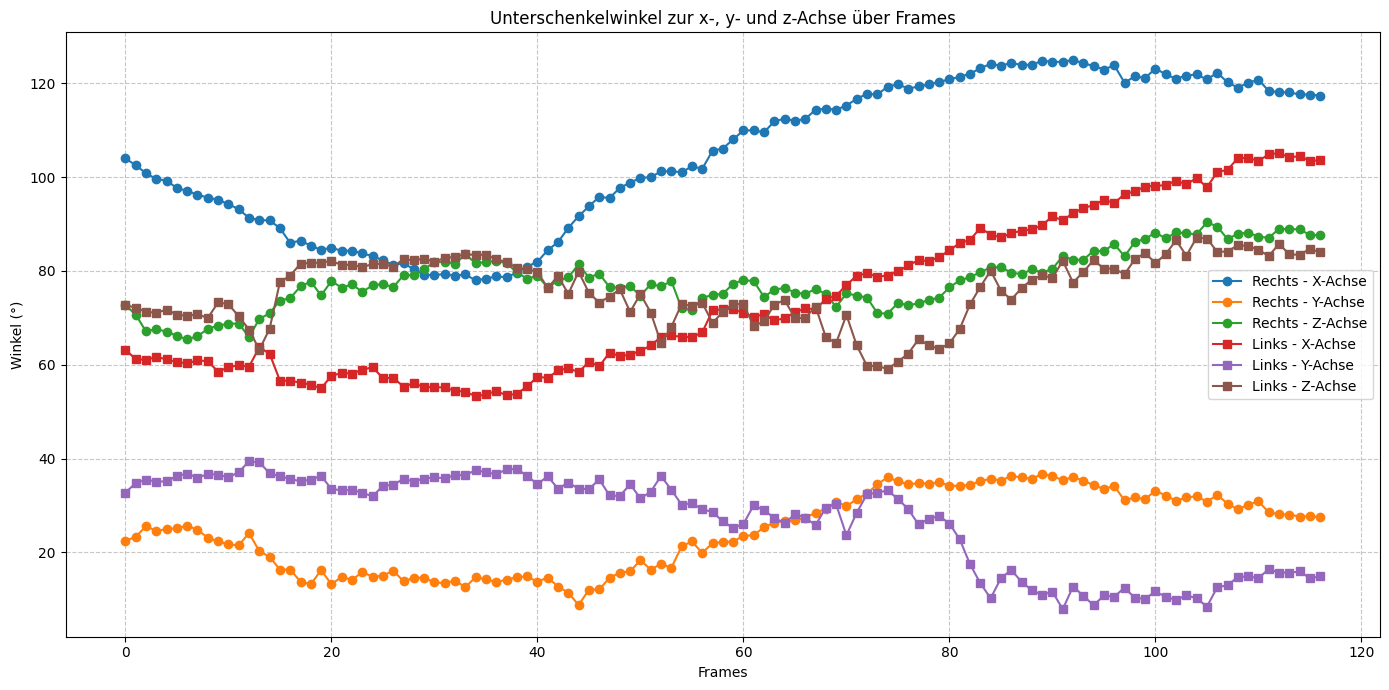

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_lower_leg_angles(lower_leg_angles):
    """
    Plottet die Winkel der Unterschenkel (rechts und links) zur x-, y- und z-Achse über alle Frames.

    Parameter:
    - lower_leg_angles (dict): Dictionary mit Frame-Nummern als Schlüsseln und
                               Dictionaries der Winkel als Werte.
    """
    frames = sorted(lower_leg_angles.keys())

    # Initialisiere Listen für jede Winkelart
    r_angle_x = []
    l_angle_x = []
    r_angle_y = []
    l_angle_y = []
    r_angle_z = []
    l_angle_z = []

    for frame in frames:
        angles = lower_leg_angles[frame]
        r_angle_x.append(angles.get("r_lower_leg_angle_x", np.nan))
        l_angle_x.append(angles.get("l_lower_leg_angle_x", np.nan))
        r_angle_y.append(angles.get("r_lower_leg_angle_y", np.nan))
        l_angle_y.append(angles.get("l_lower_leg_angle_y", np.nan))
        r_angle_z.append(angles.get("r_lower_leg_angle_z", np.nan))
        l_angle_z.append(angles.get("l_lower_leg_angle_z", np.nan))

    plt.figure(figsize=(14, 7))

    # Plot für rechte Unterschenkel
    plt.plot(frames, r_angle_x, label='Rechts - X-Achse', marker='o')
    plt.plot(frames, r_angle_y, label='Rechts - Y-Achse', marker='o')
    plt.plot(frames, r_angle_z, label='Rechts - Z-Achse', marker='o')

    # Plot für linke Unterschenkel
    plt.plot(frames, l_angle_x, label='Links - X-Achse', marker='s')
    plt.plot(frames, l_angle_y, label='Links - Y-Achse', marker='s')
    plt.plot(frames, l_angle_z, label='Links - Z-Achse', marker='s')

    plt.xlabel('Frames')
    plt.ylabel('Winkel (°)')
    plt.title('Unterschenkelwinkel zur x-, y- und z-Achse über Frames')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Beispielhafte Nutzung der Funktion
# Stelle sicher, dass dein 'lower_leg_angles'-Dictionary bereits definiert und gefüllt ist
# plot_lower_leg_angles(lower_leg_angles)

plot_lower_leg_angles(lower_leg_angles)


In [ ]:
COM_angles = {}

for i, frame in enumerate(list(result.keys())):
    COM_angle = {}

    # Berechne den Vektor vom Knöchel-Mittelpunkt zum COM
    ground_to_COM_vector = np.array(COM_xyz_values[i]) - np.array(center_ankle[i])

    # Berechne die Winkel zur x-, y- und z-Achse
    COM_x_rotation = np.degrees(np.arccos(np.dot(ground_to_COM_vector, x_vector) / (np.linalg.norm(ground_to_COM_vector) * np.linalg.norm(x_vector))))
    COM_y_rotation = np.degrees(np.arccos(np.dot(ground_to_COM_vector, y_vector) / (np.linalg.norm(ground_to_COM_vector) * np.linalg.norm(y_vector))))
    COM_z_rotation = np.degrees(np.arccos(np.dot(ground_to_COM_vector, z_vector) / (np.linalg.norm(ground_to_COM_vector) * np.linalg.norm(z_vector))))

    COM_angle["COM_x_rotation"] = COM_x_rotation
    COM_angle["COM_y_rotation"] = COM_y_rotation
    COM_angle["COM_z_rotation"] = COM_z_rotation

    COM_angles[i] = COM_angle

print(COM_angles[0])


{'COM_x_rotation': 91.45166896164078, 'COM_y_rotation': 175.531185895293, 'COM_z_rotation': 94.22554593835676}


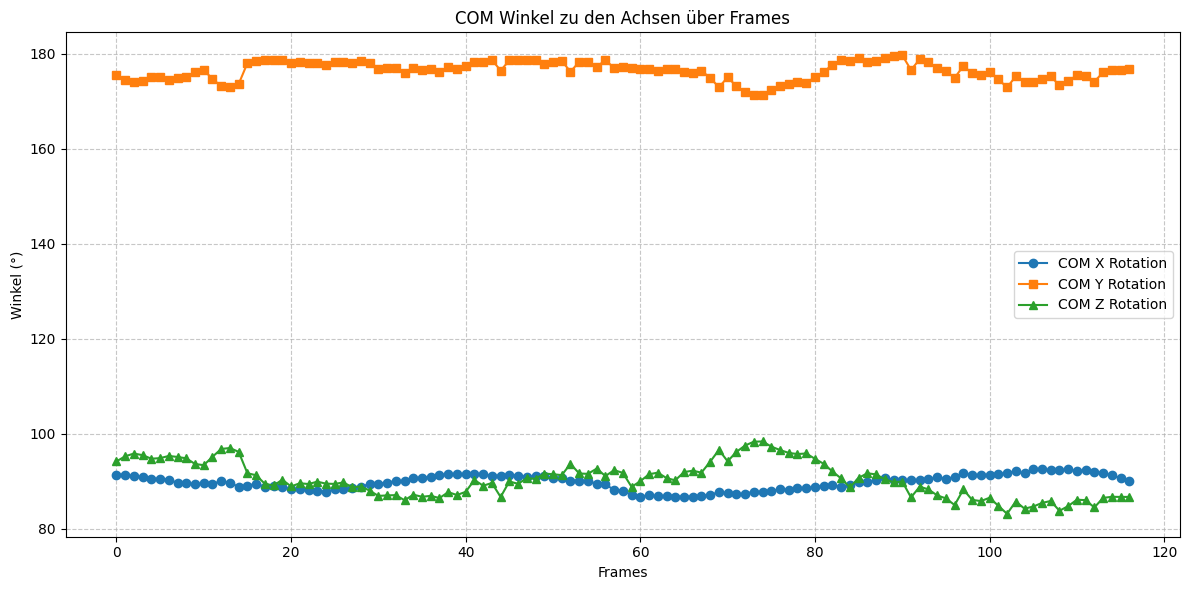

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_COM_angles(COM_angles):
    """
    Plottet die COM-Winkel zur x-, y- und z-Achse über alle Frames.

    Parameter:
    - COM_angles (dict): Dictionary mit Frame-Nummern als Schlüsseln und
                         Dictionaries der Winkel als Werte.
                         Beispiel:
                         {
                             0: {"COM_x_rotation": 30.0, "COM_y_rotation": 45.0, "COM_z_rotation": 60.0},
                             1: {"COM_x_rotation": 32.0, "COM_y_rotation": 46.0, "COM_z_rotation": 61.0},
                             ...
                         }
    """
    frames = sorted(COM_angles.keys())

    # Listen der Winkelwerte
    COM_x = [COM_angles[frame].get("COM_x_rotation", np.nan) for frame in frames]
    COM_y = [COM_angles[frame].get("COM_y_rotation", np.nan) for frame in frames]
    COM_z = [COM_angles[frame].get("COM_z_rotation", np.nan) for frame in frames]

    plt.figure(figsize=(12, 6))

    # Plot für jede Achse
    plt.plot(frames, COM_x, label='COM X Rotation', marker='o')
    plt.plot(frames, COM_y, label='COM Y Rotation', marker='s')
    plt.plot(frames, COM_z, label='COM Z Rotation', marker='^')

    # Achsenbeschriftungen und Titel
    plt.xlabel('Frames')
    plt.ylabel('Winkel (°)')
    plt.title('COM Winkel zu den Achsen über Frames')

    # Legende und Gitter
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

# Beispielhafte Nutzung der Funktion
# Stelle sicher, dass dein 'COM_angles'-Dictionary bereits definiert und gefüllt ist
plot_COM_angles(COM_angles)


In [ ]:
# Speichern der Features in pkl file - alle Features werden in Dictionary mit jeweiligem Nanen gespeichert, so kann man später auf diese zugreifen beim Training
# Feature 1: Center of Mass Distance to Ground
print(COM_to_ground)

# Feature 2: Knee Angles Right & Left
print(knee_angles_right)
print(knee_angles_left)

# Feature 3: beinhaltet Winkel für den Oberarm (Schulter zu Ellbogen), Oberschenkel (Hüfte zu Knie) sowie Unterschenkel (Knie zu Fußgelenk) zur z-Achse und x-Achse
print(angles_z)
print(angles_x)

# Feature 4: berechnet den Unterschenkelwinkel zu allen drei Achsen
print(lower_leg_angles)

# Feature 5: Center of Mass Winkel zu den drei Achsen -> die Achsen sind immer ein globaler referenzvektor (1, 0, 0), (0, 1, 0), (0, 0, 1)
print(COM_angles)

{0: 0.83516055, 1: 0.83531225, 2: 0.8258441, 3: 0.8233454, 4: 0.8134174, 5: 0.808589, 6: 0.809546, 7: 0.8108446, 8: 0.8079058, 9: 0.80322814, 10: 0.80321217, 11: 0.7997785, 12: 0.788425, 13: 0.7929602, 14: 0.78522795, 15: 0.7817862, 16: 0.7795192, 17: 0.7715101, 18: 0.7714118, 19: 0.7654959, 20: 0.7735648, 21: 0.7695321, 22: 0.7670833, 23: 0.7636223, 24: 0.7623254, 25: 0.75666046, 26: 0.7539136, 27: 0.75270075, 28: 0.75509053, 29: 0.75143194, 30: 0.75414115, 31: 0.7570532, 32: 0.76489687, 33: 0.7735289, 34: 0.7897625, 35: 0.7994213, 36: 0.8149826, 37: 0.82652134, 38: 0.8428307, 39: 0.8455673, 40: 0.8630697, 41: 0.87122834, 42: 0.8809966, 43: 0.8800359, 44: 0.8854804, 45: 0.8947362, 46: 0.889527, 47: 0.9010812, 48: 0.90366524, 49: 0.90048194, 50: 0.90168905, 51: 0.8974404, 52: 0.89560395, 53: 0.8942573, 54: 0.88930565, 55: 0.88446933, 56: 0.8838185, 57: 0.88569283, 58: 0.88442343, 59: 0.8735657, 60: 0.86955655, 61: 0.86682963, 62: 0.8604068, 63: 0.8600429, 64: 0.86103797, 65: 0.8538127,

In [ ]:
import pickle

# Features in ein Dictionary packen
features_dict = {
    "COM_to_ground": COM_to_ground,
    "knee_angles_right": knee_angles_right,
    "knee_angles_left": knee_angles_left,
    "angles_z": angles_z,
    "angles_x": angles_x,
    "lower_leg_angles": lower_leg_angles,
    "COM_angles": COM_angles
}

# Als .pkl speichern
with open("features.pkl", "wb") as pkl_file:
    pickle.dump(features_dict, pkl_file)

# Als .txt speichern (für visuelle Überprüfung)
with open("features.txt", "w") as txt_file:
    for key, value in features_dict.items():
        txt_file.write(f"{key}:\n{value}\n\n")

print("Speicherung abgeschlossen: 'features.pkl' und 'features.txt'")


Speicherung abgeschlossen: 'features.pkl' und 'features.txt'


In [ ]:
import pickle

# 🔹 Features laden (falls sie schon gespeichert wurden)
with open("features.pkl", "rb") as pkl_file:
    features_dict = pickle.load(pkl_file)

num_frames = len(features_dict["COM_to_ground"])
print(num_frames)

labels = {}

schwungbereiche = [
  (0, 40, 1),
  (41, 80, 2),
  (81, 117, 1),
]

for start, end, schwungbereich in schwungbereiche:
  for i in range(start, end + 1):
    labels[i] = schwungbereich


# 🔹 Labels in Dictionary speichern
features_dict["Schwung_labels"] = labels

# 🔹 Neue Daten speichern (mit Labels)
with open("features_with_labels.pkl", "wb") as pkl_file:
    pickle.dump(features_dict, pkl_file)

with open("features_with_labels.txt", "w") as txt_file:
    for key, value in features_dict.items():
        txt_file.write(f"{key}:\n{value}\n\n")

print("Speicherung abgeschlossen: 'features_with_labels.pkl' und 'features_with_labels.txt'")


117
Speicherung abgeschlossen: 'features_with_labels.pkl' und 'features_with_labels.txt'
